In [2]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\brown\miniconda3\envs\mainenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


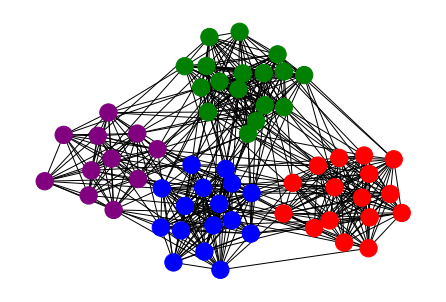

In [11]:
def generate_SBM(n,connection_matrix,edge_possibility,class_possibility):
    """This creates a random graph based on:
        n : how many node we have
        connection_matrix : the likelihood of a node in cluster i connecting to a node in cluster j
        edge_possibility : the likelihood of an edge existing between two nodes
        class_possibility : the likelihood of belonging to any given class"""
    num_clusters = len(class_possibility)
    cluster_assignments = np.sort(np.random.choice(np.arange(num_clusters),p=class_possibility,size=n))
    cluster_indices = [cluster_assignments == a for a in range(num_clusters)]
    cluster_assignments = np.expand_dims(cluster_assignments,1)
    #clusters = cluster_assignments == cluster_assignments.T
    probabilities = np.random.random((n,n))
    adj = np.zeros((n,n))
    for i in range(num_clusters):

        for j in range(num_clusters):
            mask = np.zeros((n,n),dtype=bool)
            imask = np.zeros((n,n))
            imask[cluster_indices[i]] = ~mask[cluster_indices[i]]
            if(len(cluster_indices[i]) !=0 and len(cluster_indices[j]) != 0):
                jmask = np.zeros((n,n))
                jmask[:,cluster_indices[j]] =  ~mask[:,cluster_indices[j]]
                total_mask = jmask*imask
                probs = probabilities

                probs = probs < (connection_matrix[i,j]*edge_possibility)
                #print(probs)
                probs = (total_mask*1)*probs
                #print(probs)
                adj += probs
    tri = np.tri((n),k=-1)
    adj = adj* tri
    adj += adj.T
    #print(cluster_assignments)
    return adj,cluster_assignments
    

    
adj,cluster_assignments = generate_SBM(60,np.array([[1,.1,.1,.1],[.1,1,.1,.1],[.1,.1,1,.1],[.1,.1,.1,1]]),1,[.25,.25,.25,.25])
g = nx.from_numpy_matrix(adj)
pos = []
color_map = []
for i in range(60):
    if(cluster_assignments[i] == 0):
        pos.append(((0+np.random.random(1)-.5)/2,(0+np.random.random(1)-.5)/2))
        color_map.append("blue")
    elif(cluster_assignments[i] == 1):
        pos.append((.5,.25))
        color_map.append("red")
    elif(cluster_assignments[i] == 2):
        pos.append((.25,.5))
        color_map.append("green")
    else:
        color_map.append("purple")
nx.draw_spring(g,node_color=color_map)
plt.show()



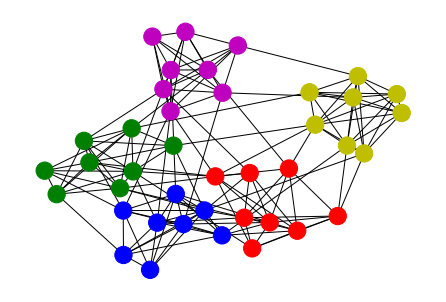

In [40]:
def generate_SSBM(n,c,p_intra,p_inter):
    """This is similar to the above SBM but in this case it is symmetric"""
    # assign a community to each node
    community = np.repeat(list(range(c)),np.ceil(n/c))
    
    #np.repeat(list to iterate over, how many times to repeat an item)

    #make sure community has size n
    community = community[0:n]
    communities = community.copy()
    # just in case repeat repeated too many

    # make it a collumn vector
    community = np.expand_dims(community,1)

    # generate a boolean matrix indicating whether 
    # two nodes share a community
    # this is a smart way to generate a section graph
    intra = community == community.T
    inter = community != community.T# we can also use np.logical not

    random = np.random.random((n,n))
    tri = np.tri(n,k=-1).astype(bool)

    intergraph = (random < p_intra) * intra * tri# this creates a matrix that only has trues where
                                                # random< p_intra, they are in intra, and along half the matrix
                                                # (if it were the whole matrix it would be double the edges we want)
    intragraph = (random < p_inter) * inter * tri# same thing here
    graph = np.logical_or(intergraph,intragraph)
    graph = graph*1# this converts it to a int tensor
    graph += graph.T
    return graph,communities
adj,communities = generate_SSBM(40,5,.9,.05)
g = nx.from_numpy_matrix(adj)
colors = np.ones((40),dtype=str)
colors[np.where(communities == 0)] = "green"
colors[np.where(communities == 1)] = "blue"
colors[np.where(communities == 2)] = "red"
colors[np.where(communities == 3)] = "m"
colors[np.where(communities == 4)] = "yellow"
nx.draw_spring(g,node_color = colors)
    

The following code implements the algorithm outlined in the cSBM paper

\begin{equation}
  \mathbb{P}(A_{ij}^{G} = 1)=
  \begin{cases}
    c_{in}/n, & \text{if both i and j are in the same cluster}\ \\
    c_{out}/n, & \text{otherwise}\
  \end{cases}
\end{equation}
\begin{equation}
b_{i}=\sqrt{\frac{\mu}{n}}v_{i}u+\frac{Z_i}{\sqrt{p}}
\end{equation}
\begin{equation}
c_{in} = d+\lambda \sqrt{d}, c_{out}=d-\lambda \sqrt{d}
\end{equation}
u is a normal random vector drawn before everything else is computed, $u\in \mathbb{R}^{p}$<br>
Z is a normal random matrix, likewise drawn before anything else is computed, $Z \in \mathbb{R}^{n\times p}$<br>
v is also a vector that encodes the partitioning of the clusters, $v \in {\{0,1\}}^{n}$


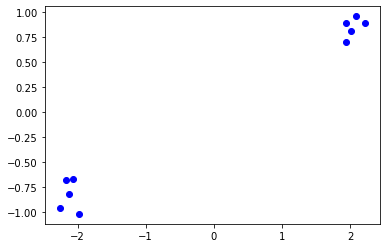

In [38]:
def generate_cSBM(d,lamb,mu,num_features,num_nodes):
    c_in = d+lamb*np.sqrt(d) # c_in/c_out as described in the equations
    c_out = d-lamb*np.sqrt(d) 
    p_in = c_in/num_nodes # compiles these to pass into the SSBM
    p_out = c_out/num_nodes
    
    adj, communities = generate_SSBM(num_nodes,2,p_in,p_out) # obtains the graph structure
    u = np.random.normal(0,1/num_features,(num_features)) # obtains the random normal vector u
    Z = np.random.normal(0,.2,(num_nodes,num_features)) # obtains the random noise vector i presume
    v = (communities-.5)*2 # puts the groups into a format for the equations
    
    b = np.zeros((num_nodes,num_features))
    for i in range(num_nodes):
        b[i] = np.sqrt(mu/num_nodes)*v[i]*u + Z[i]/np.sqrt(num_features)
    return adj,b



adj,b = generate_cSBM(1,.5,250,2,10)
plt.plot(b[:,0],b[:,1],"bo")